In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram
from qiskit.circuit import IfElseOp
import matplotlib.pyplot as plt

## First Circuits

It's simple to create a quantum circuit in qiskit. Let's do a very basic example to get started.

### Registers
Circuits in qiskit are actually built up of registers.

Often we'll use quantum registers with qubits and classical registers with bits.

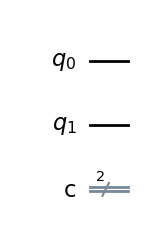

In [2]:
qr = QuantumRegister(2, 'q')
cr = ClassicalRegister(2, 'c')
circ = QuantumCircuit(qr,cr)
circ.draw('mpl')

### Gates

Circuits have the common gates built in as functions. For example, the Hadamard gate is just `h`.

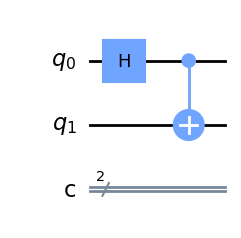

In [3]:
circ.h(0)
circ.cx(0, 1)
circ.draw('mpl')

These will be applied in order from top to bottom of your code, so they go on the circuit from left to right.

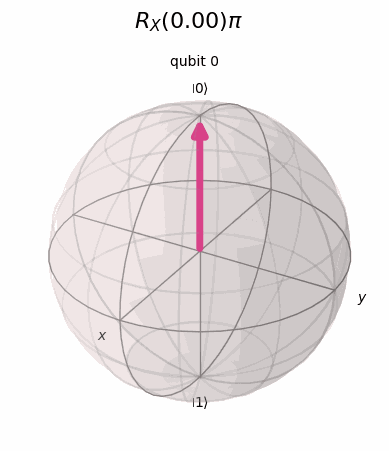

In [4]:
# play Bloch gifs from files
from IPython.display import Image
Image(filename='Bloch_R_X.gif')

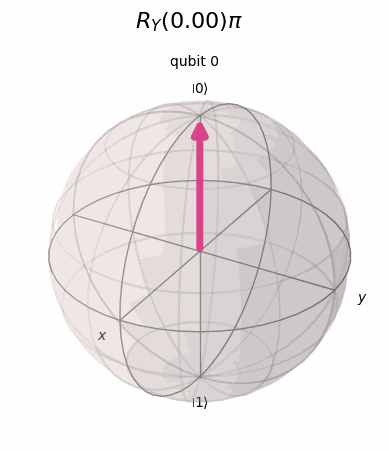

In [5]:
Image(filename='Bloch_R_Y.gif')

The Z rotation gate doesn't do anything to the $|0\rangle$ state, but it does rotate the $|+\rangle$ state which is created by a Hadamard.

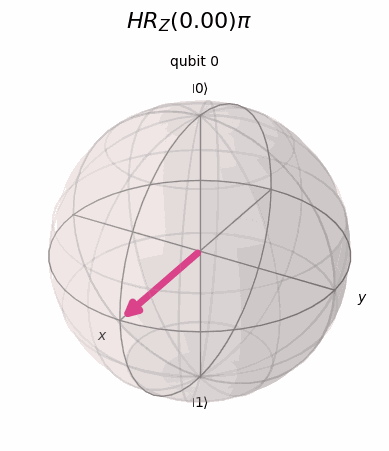

In [6]:
Image(filename='Bloch_HR_Z.gif')

### Measurements

Finally, we can measure the qubits in our circuit. This will collapse the qubits into a classical bit.

This is why we needed a quantum register and a classical register.

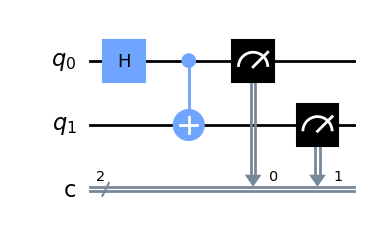

In [7]:
circ.measure(qubit=0, cbit=0)
circ.measure(qubit=1, cbit=1)
circ.draw('mpl')

We can predict what we think this circuit will do by using our Dirac notation, which uses operators $\hat{U}$ and states $|\Psi\rangle$.

At first, the qubit $q_0$ and $q_1$ are in state $|0\rangle$.

$$|\Psi\rangle = |0\rangle \otimes |0\rangle$$

Then, we apply a Hadamard gate to $q_0$ an the identity to $q_1$.

$$\hat{H} \otimes \hat{I} |\Psi\rangle$$

$$= \frac{1}{\sqrt{2}} \left( |0\rangle + |1\rangle \right) \otimes |0\rangle$$

$$= \frac{1}{\sqrt{2}} \left( |00\rangle + |10\rangle \right)$$

Then, we apply a CNOT gate to $q_0$ and $q_1$.

$$\hat{U_{CN}} (\hat{H} \otimes \hat{I}) |\Psi\rangle$$

$$=\hat{U_{CN}} \frac{1}{\sqrt{2}} \left( |00\rangle + |10\rangle \right)$$

$$=\frac{1}{\sqrt{2}} \left( \hat{U_{CN}} |00\rangle + \hat{U_{CN}} |10\rangle \right)$$


$$=\frac{1}{\sqrt{2}} \left( |00\rangle + |11\rangle \right)$$

This type of state is called a Bell State. It is a superposition of two states, $|00\rangle$ and $|11\rangle$.

### Question: What are the probabilities of measuring $|00\rangle$ and $|11\rangle$?

To find a result, we need to use either a quantum computer or a simulator. We'll use the simulator for now.

In [8]:
from qiskit import Aer
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = backend_sim.run(circ, shots=1024)

Now we're ready to see the results.

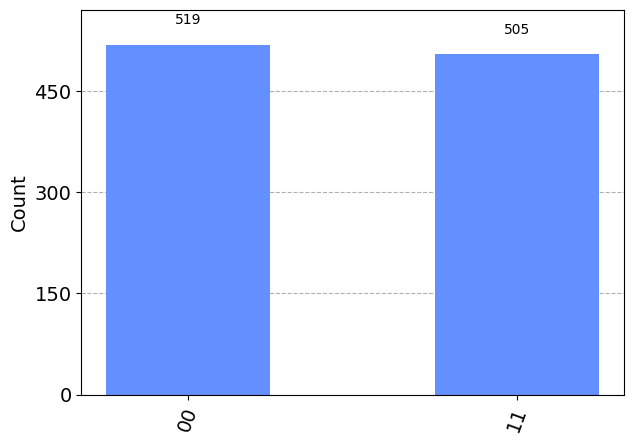

In [9]:
from qiskit.visualization import plot_histogram

# Grab the results from the job.
result_sim = job_sim.result()
counts = result_sim.get_counts(circ)
plot_histogram(counts)

### Question: Did these measurements match our predictions?

Lets create a function to plot the results from a circuit, we'll use this later.

In [10]:
def get_counts(circ):
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = backend_sim.run(circ, shots=1024)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(circ)
    return counts

## Mixing classical and quantum operations

Sopmetimes we want to perform an operation based on the result of a measurement.

Qiskit allows us to do this by using a context manager.

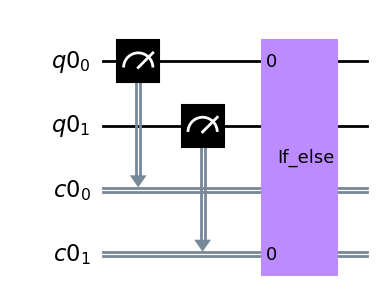

In [11]:
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
qc=QuantumCircuit(qr, cr)


qc.measure(qr, cr)

with qc.if_test((cr[1], 0)):
    qc.x(0)


qc.draw('mpl')

In the example above, we checked if the first classical register contained a 0. 

If it does, we apply an x gate to the first qubit.

These are quite ugly gates in the qiskit diagrams sadly.

# Quantum Teleportation

As an example, we'll learn how to make a circuit that performs quantum teleportation.

Imagine we have two people, Alice and Bob. Initially they're in the same room. Alice has a qubit in state $|\Psi\rangle$ and Bob has a qubit $q_1$ in state $|0\rangle$.

To make the teleportation work later, we also give Alice an extra **ancilla** qubit $q_0$ in state $|0\rangle$.

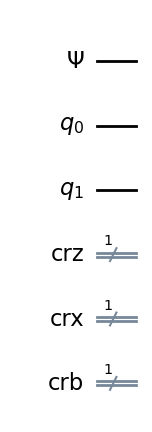

In [12]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
# Include a third register for measuring Bob's result
aqr = QuantumRegister(1, name='\Psi')
qr = QuantumRegister(2, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
crb = ClassicalRegister(1, name="crb")
teleport = QuantumCircuit(aqr, qr, crz, crx, crb)
teleport.draw('mpl')

All qubits start in state $|0\rangle$ so let's apply a gate to get a more interesting state for $|\Psi\rangle$

You can use any gate you want, but I've used an X.

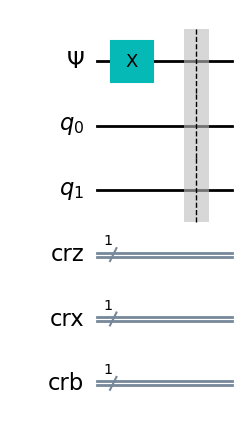

In [13]:
teleport.x(0)
teleport.barrier()
teleport.draw('mpl')

## Step 1: Create an entangled pair
We're going to give $q_0$ to Alice and $q_1$ to Bob but first we need to entangle them. 

Do this by following the proceduce from earlier to create a Bell state.

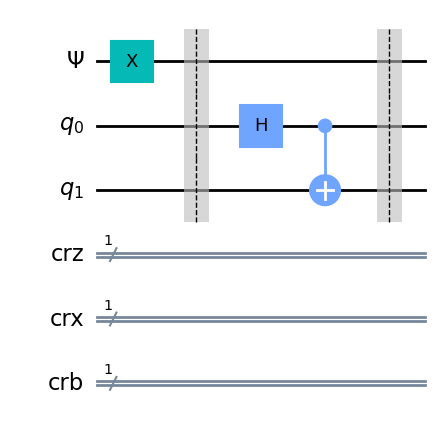

In [14]:
teleport.h(1)
teleport.cx(1, 2)
teleport.barrier()
teleport.draw('mpl')

Alice now takes her qubits to the other side of the planet, or Mars.

## Step 2: Apply a CNOT and Hadamard to Alice's qubits

We do a similar operation to Alice's qubits $ q_0 $ and $|\Psi \rangle$

- Apply a Cx gate with $|\Psi \rangle$ as the control qubit and $ q_0 $ as the target.
- Apply a Hadamard gate to $|\Psi \rangle$

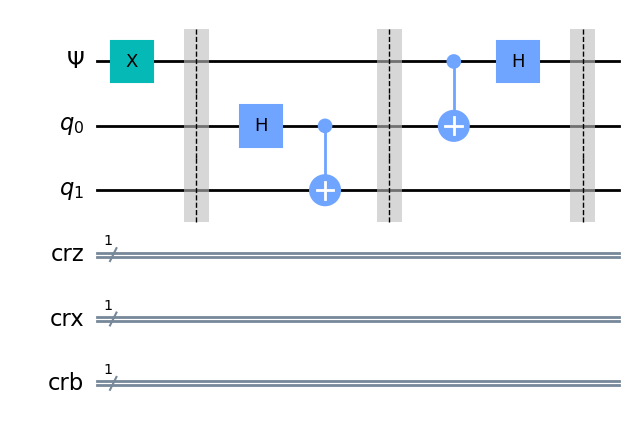

In [15]:
teleport.cx(0, 1)
teleport.h(0)
teleport.barrier()
teleport.draw('mpl')

## Step 3: Measure Alice's qubits

Now take a measurement of Alice's qubits $|\Psi\rangle$ and $q_0$

Put the results in `crz` and `crx` respectively.

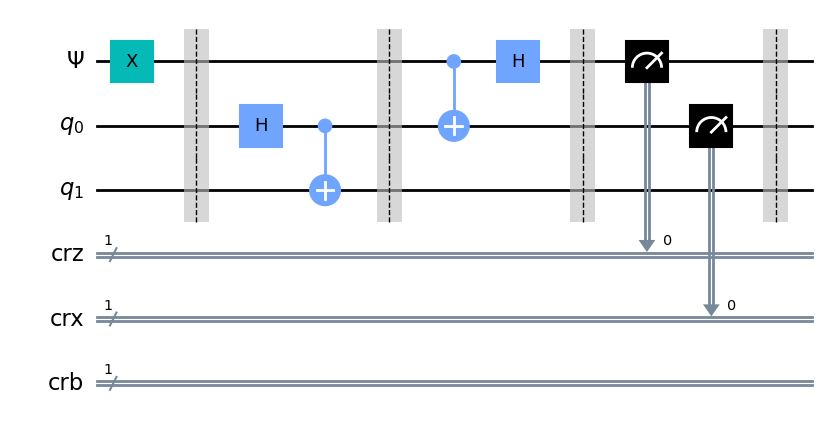

In [16]:
teleport.measure(0, 0)
teleport.measure(1, 1)
teleport.barrier()
teleport.draw('mpl')

We then send the outcomes of these measurements to Bob.

## Step 4: Bob applies gates

Depending on the classical bits sent from Alice, Bob applies the following gates to his qubit:

00: Do nothing

01: Apply $X$

10: Apply $Z$

11: Apply $ZX$

Implement this using the `if_test` context manager for our circuit.

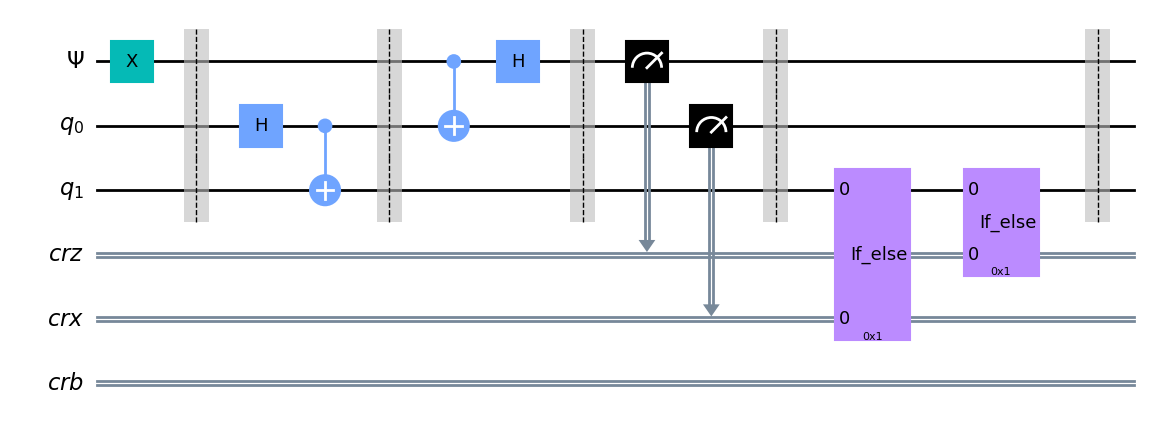

In [17]:
with teleport.if_test((crx, 1)):
    teleport.x(2)
with teleport.if_test((crz, 1)):
    teleport.z(2)
teleport.barrier()
teleport.draw('mpl')

### Step 5: Bob measures his qubit

Bobs qubit should now be in the state we prepared for Alice earlier $|\Psi\rangle$.

To check this we'll need to make measurements.

Measure and put this bit into $q_1$ to $crb$.

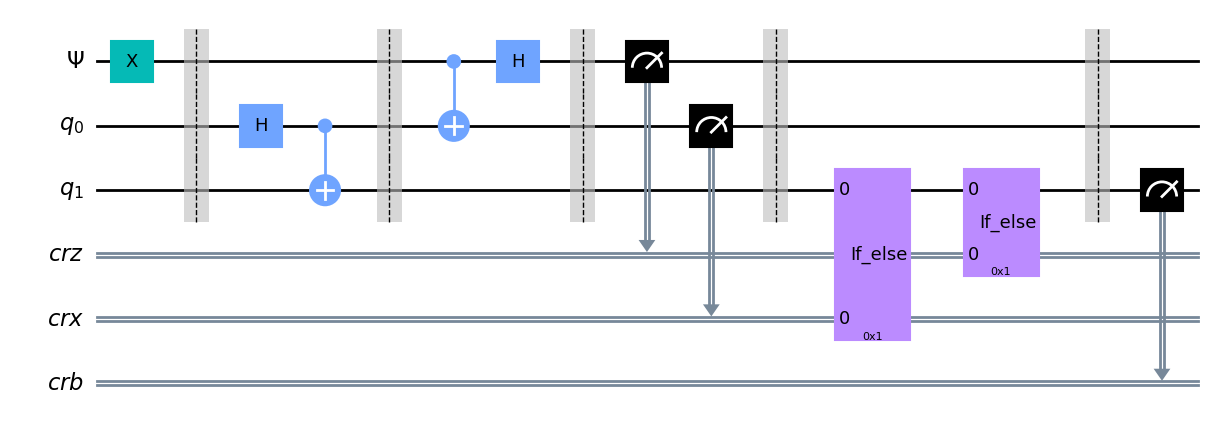

In [18]:
teleport.measure(2, 2)
teleport.draw('mpl')

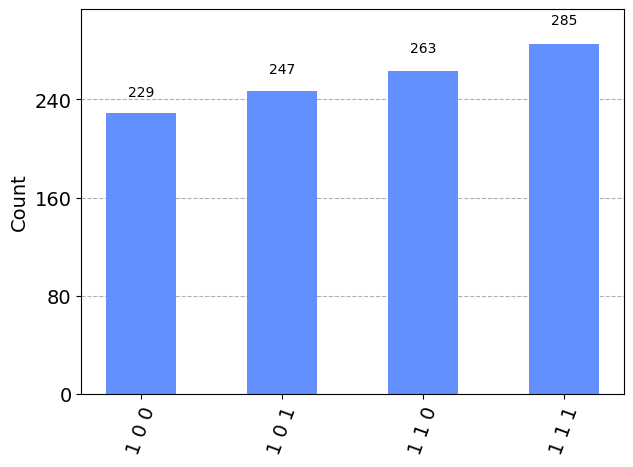

In [19]:
plot_histogram(get_counts(teleport))

We only really care about the values for $q_1$ because we want to check if our teleportation protocol worked.

We can check this using the marginal counts function as below.

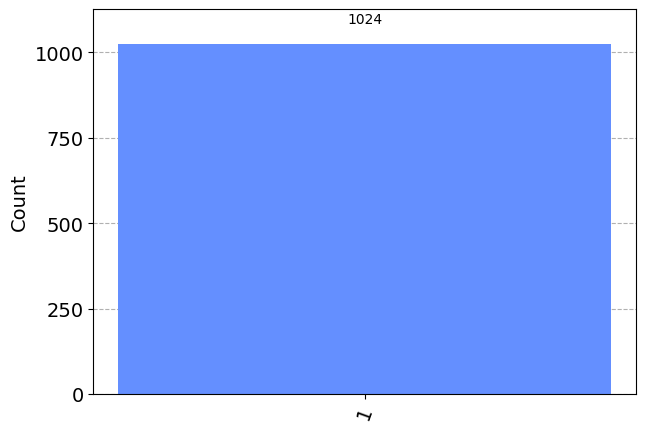

In [20]:
from qiskit.result import marginal_counts
bobs_count = marginal_counts(get_counts(teleport), [2])
plot_histogram(bobs_count)